In [62]:
import re
import random
import pandas as pd
import hashlib

In [63]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [64]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Do Androids Dream of Electric Sheep? Dick,7.090019,1.418004,2.902733,5
"Jane Eyre, Bronte",111.738081,13.967260,21.185532,8
Azure Functions + Visual Studio,189.959697,63.319899,144.047771,3
Azure AD Authentication,456.053476,38.004456,108.235026,12
Email Auth and Security,464.546659,58.068332,137.746329,8
Logging in Python,475.953080,33.996649,76.099667,14
RAG Project,800.543242,80.054324,225.195535,10
Debugging in VS Code,946.770448,86.070041,214.160740,11
Azure Private DNS,995.498972,52.394683,123.812633,19
C# Basics,1175.672981,37.924935,108.459252,31


# Histogram

sum of ages: ~35987.44


<Axes: >

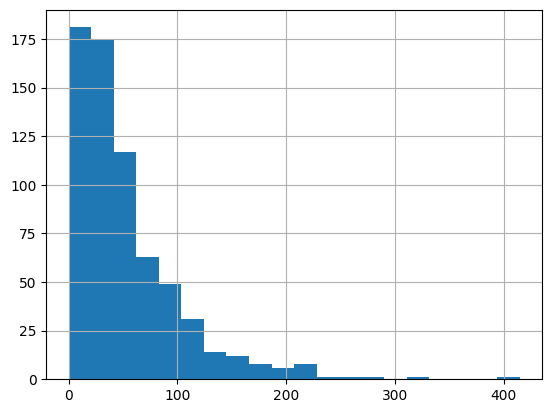

In [65]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~35987.44


<Axes: >

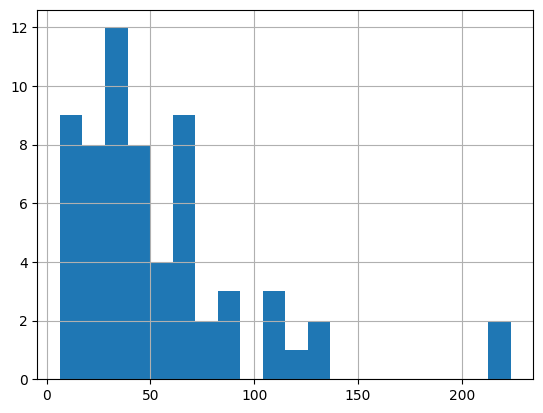

In [66]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [67]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [68]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [69]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [70]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [71]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [72]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [73]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [74]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [75]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [76]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [77]:
n=5
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 669
Total card age: 35987.44


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
0,Azure Functions + Visual Studio,ASP.NET Web API is a framework for building HT...,8778d1d9428fa841dd48d609cb8ba53f,144.047771,63.319899,144.047771,189.959697,0.829675,3,0,0,-144.047771
1,Azure Functions + Visual Studio,ASP.NET Razor syntax is a streamlined way to i...,18f6987fdbfca0ab82263df195969e68,30.958747,63.319899,144.047771,189.959697,0.829675,3,1,0,-30.958747
2,Azure Functions + Visual Studio,ASP.NET includes a variety of built-in securit...,22f41dbaa7f06bfee2174c4754c8f951,14.953179,63.319899,144.047771,189.959697,0.829675,3,2,0,-14.953179
208,Do Androids Dream of Electric Sheep? Dick,Cephalic pattern (suh-FAL-ik PAT-ern): Refers ...,310d068765201e0e82135fb01d1a5e78,2.902733,1.418004,2.902733,7.090019,0.258898,5,0,0,-2.902733
654,Do Androids Dream of Electric Sheep? Dick,Jug-eared (JUHG-eerd): Describing someone with...,8672ae968b6b532835319a4789b7eea5,1.895162,1.418004,2.902733,7.090019,0.258898,5,1,0,-1.895162
286,Do Androids Dream of Electric Sheep? Dick,"Caterwauled (KAT-er-wawld): Past tense of ""cat...",e0d5418fcba056043cbe9db9b68ebc68,1.452110,1.418004,2.902733,7.090019,0.258898,5,2,0,-1.452110
607,Do Androids Dream of Electric Sheep? Dick,Kipple (KIP-uhl): A term coined by author Phil...,087bf4b74ec5d79f84513edb5dad7fdc,0.778301,1.418004,2.902733,7.090019,0.258898,5,3,0,-0.778301
606,Do Androids Dream of Electric Sheep? Dick,"Cogitated (KOJ-i-teyt-ed): Past tense of ""cogi...",43b7b6ed69e2071e68043d97b76820b2,0.061713,1.418004,2.902733,7.090019,0.258898,5,4,0,-0.061713
3,Email Auth and Security,p=quarantine\n\nA DMARC policy action.\nInstru...,ef938783fc320a6d315dde8501f4b254,137.746329,58.068332,137.746329,464.546659,0.142686,8,0,0,-137.746329
4,Email Auth and Security,Email Authentication Alignment\n\nEnsuring tha...,14bc6ca0af379197455f1cd5febad55c,94.125236,58.068332,137.746329,464.546659,0.142686,8,1,0,-94.125236



## Random

In [78]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [79]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
88,Asynchronous Python,Awaitable\nAny object in Python that can be us...,56b47f1b55955533a2140918db6d5be0,414.643456,71.615419,414.643456,3294.309294,0.126355,46,0,0,-414.643456
68,PowerShell Modules,Module Scope Management\n\nDefinition: Control...,2ebf820a231a01c49801fca43af0a504,322.909166,73.518236,322.909166,2720.174719,0.563843,37,0,0,-322.909166
43,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,284.915001,61.635804,284.915001,1479.259307,0.620852,24,0,0,-284.915001
58,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,249.504174,75.629367,249.504174,2420.139732,0.020252,32,0,0,-249.504174
93,PnP PowerShell,Set-PnPList (PnP.PowerShell)\nModifies propert...,ec61ff7f95b8fe03595feae81fd53798,239.803819,50.292338,239.803819,2766.078569,0.185868,55,0,0,-239.803819
13,RAG Project,Factory Function (create_app)\nA function that...,b8e2a1f3abaa53ee84f1f660c74697fe,225.195535,80.054324,225.195535,800.543242,0.474843,10,0,0,-225.195535
48,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,224.103988,65.515238,224.103988,1703.396178,0.643946,26,0,0,-224.103988
98,Azure Developer Associate,Which two parameters are mandatory for ReadIte...,30b4e50f9b3e9f37a1f858991c1f2f26,223.521720,55.022887,223.521720,3466.441862,0.078917,63,0,0,-223.521720
99,Azure Developer Associate,Name two platform features that Azure Containe...,1a632a38fa677acc080d6955644c10df,220.059693,55.022887,223.521720,3466.441862,0.078917,63,1,0,-220.059693
78,JavaScript Concepts,"Heroku: A cloud platform for deploying, managi...",81c33c8653348fa2529f220a4a2e60b1,216.451782,59.704580,216.451782,2447.887793,0.375230,41,0,0,-216.451782


In [80]:
existing_cards.head(10).sum()

head                   Azure Functions + Visual StudioAzure Functions...
body                   ASP.NET Web API is a framework for building HT...
hash                   8778d1d9428fa841dd48d609cb8ba53f18f6987fdbfca0...
age                                                            428.92128
subject_mean_age                                               313.18638
subject_highest_age                                           722.149635
subject_age_sum                                              1534.422503
head_random_roll                                                4.068885
frequency                                                             50
count                                                                 14
n_fold                                                                 0
neg_age                                                       -428.92128
dtype: object

In [81]:
existing_cards['age'].mean()

53.7928824797039